<a href="https://colab.research.google.com/github/CS7140/PA-7/blob/main/Q6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Rajesh Sakhamuru

11-7-2020
# DenseNet Implementation
DenseNet implementation is below:

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [3]:
with strategy.scope():
    (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

    train_labels = tf.convert_to_tensor(train_labels)
    test_labels = tf.convert_to_tensor(test_labels)

    train_images = train_images.reshape((train_images.shape[0], 28, 28, 1))
    test_images = test_images.reshape((test_images.shape[0], 28, 28, 1))

    # resizes images and pads resized image with 0s so convolutions+pooling don't shrink
    # resolution too much
    train_images = tf.image.resize_with_pad(train_images, 112, 112)
    test_images = tf.image.resize_with_pad(test_images, 112, 112)

    train_images = tf.convert_to_tensor((train_images) / 255)
    test_images = tf.convert_to_tensor((test_images) / 255)

In [4]:
class convBlock(tf.keras.layers.Layer):
    def __init__(self, numFilters):
        super(convBlock, self).__init__()
        self.block = tf.keras.Sequential()
        self.block.add(tf.keras.layers.BatchNormalization())
        self.block.add(tf.keras.layers.ReLU())
        self.block.add(tf.keras.layers.Conv2D(filters=numFilters, kernel_size=(3, 3), padding='same'))
    
    def call(self, X):
        Y = X
        Y = self.block(Y)
        Y = tf.keras.layers.concatenate([X,Y], axis=-1)
        return Y

In [5]:
class denseBlock(tf.keras.layers.Layer):
    def __init__(self, numConvs, numFilters):
        super(denseBlock, self).__init__()
        self.block = tf.keras.Sequential()
        for _ in range(numConvs):
            self.block.add(convBlock(numFilters))
    
    def call(self, X):
        return self.block(X)

In [6]:
class transitionBlock(tf.keras.layers.Layer):
    def __init__(self, numFilters):
        super(transitionBlock, self).__init__()
        self.block = tf.keras.Sequential()
        self.block.add(tf.keras.layers.BatchNormalization())
        self.block.add(tf.keras.layers.ReLU())
        self.block.add(tf.keras.layers.Conv2D(numFilters, kernel_size=1))
        self.block.add(tf.keras.layers.AvgPool2D(pool_size=2, strides=2))
    
    def call(self, X):
        return self.block(X)

In [7]:
def denseNet(lr=0.1):
    densNet = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')
    ])
    
    densNet.add(denseBlock(4, 32))
    densNet.add(transitionBlock(96))
    densNet.add(denseBlock(4, 32))
    densNet.add(transitionBlock(112))
    densNet.add(denseBlock(4, 32))
    densNet.add(transitionBlock(120))
    densNet.add(denseBlock(4, 32))

    densNet.add(tf.keras.layers.BatchNormalization())
    densNet.add(tf.keras.layers.ReLU())
    densNet.add(tf.keras.layers.GlobalAvgPool2D())
    densNet.add(tf.keras.layers.Flatten())
    densNet.add(tf.keras.layers.Dense(10))

    optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    densNet.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    return densNet

In [8]:
def plotAccuracyAndLoss(history, epochs):
    plt.title("Train vs Test Accuracy over Epochs")
    plt.plot(range(1,epochs+1), history.history['accuracy'], 'b-', label='train accuracy')
    plt.plot(range(1,epochs+1), history.history['val_accuracy'], 'r-', label='test accuracy')
    plt.ylabel("accuracy")
    plt.xlabel("epoch number")
    plt.legend()
    plt.show()

    plt.title("Train vs Test Loss over Epochs")
    plt.plot(range(1,epochs+1), history.history['loss'], 'b-', label='train loss')
    plt.plot(range(1,epochs+1), history.history['val_loss'], 'r-', label='test loss')
    plt.ylabel("loss")
    plt.xlabel("epoch number")
    plt.legend()
    plt.show()

Epoch 1/10
469/469 - 46s - loss: 0.4726 - accuracy: 0.8285 - val_loss: 1.0482 - val_accuracy: 0.6593
Epoch 2/10
469/469 - 44s - loss: 0.2868 - accuracy: 0.8953 - val_loss: 0.6049 - val_accuracy: 0.7674
Epoch 3/10
469/469 - 44s - loss: 0.2420 - accuracy: 0.9110 - val_loss: 0.3099 - val_accuracy: 0.8866
Epoch 4/10
469/469 - 44s - loss: 0.2122 - accuracy: 0.9216 - val_loss: 0.2554 - val_accuracy: 0.9090
Epoch 5/10
469/469 - 44s - loss: 0.1910 - accuracy: 0.9300 - val_loss: 0.2353 - val_accuracy: 0.9167
Epoch 6/10
469/469 - 44s - loss: 0.1765 - accuracy: 0.9353 - val_loss: 0.3630 - val_accuracy: 0.8671
Epoch 7/10
469/469 - 44s - loss: 0.1611 - accuracy: 0.9404 - val_loss: 0.2895 - val_accuracy: 0.8981
Epoch 8/10
469/469 - 44s - loss: 0.1494 - accuracy: 0.9444 - val_loss: 0.3035 - val_accuracy: 0.8949
Epoch 9/10
469/469 - 44s - loss: 0.1394 - accuracy: 0.9482 - val_loss: 0.2976 - val_accuracy: 0.8970
Epoch 10/10
469/469 - 44s - loss: 0.1266 - accuracy: 0.9541 - val_loss: 0.2530 - val_accura

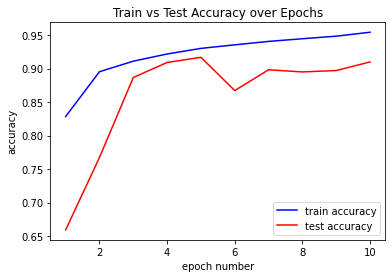

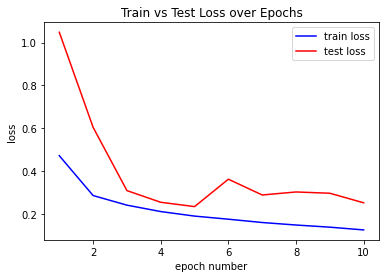

In [10]:
with strategy.scope():
    densNet = denseNet(lr=0.1)
    history1 = densNet.fit(train_images, train_labels, epochs=10, batch_size=128, validation_data=(test_images, test_labels), verbose=2)
    plotAccuracyAndLoss(history1,10)

As we can see in the DenseNet model summary below, DenseNet when trained on 112x112 pixel images has 764,834 parameters while ResNet had an order of magnitude more at 11,186,186 parameters. 

DenseNet, like ResNet obtains additional inputs from all preceding layers, however rather than use addition, concatanation is used. The advantage of using concatanation is that the following layers recieve a collective knowledge of the prior layers rather than just a summed knowledge without descreetly knowing how each layer contributed to the sum. The reason that DenseNet's model parameters is smaller than ResNet is because since each layer gets what are essentially feature maps of all preceding layers, DenseNet can have fewer channels added in each subsequent layer and still achieve the accuracy of ResNet while being sleeker and requiring fewer computational resources.

In [11]:
densNet.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 56, 56, 64)        3200      
_________________________________________________________________
batch_normalization_21 (Batc (None, 56, 56, 64)        256       
_________________________________________________________________
re_lu_21 (ReLU)              (None, 56, 56, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
dense_block_4 (denseBlock)   (None, 28, 28, 192)       130944    
_________________________________________________________________
transition_block_3 (transiti (None, 14, 14, 96)        19296     
_________________________________________________________________
dense_block_5 (denseBlock)   (None, 14, 14, 224)     